# Assignment 

In this assignment, we will design a regression model by using the [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset from Kaggle. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. 

We will familiarize ourselves with the data by performing EDA to identify trends, spot anaomiles, select features, and more. Once this stage is complete, we will split our data into train and test sets where 20% of the data resides in the test set. Then, we will build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. We will also use k-fold cross-validation to select the best hyperparameters for our models. Once we evaluate our best model on the test set, we will introduce addition factors that may affect house prices. 


In [1]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistics tools
import scipy.stats as stats

# Model prep and Modeling 
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

# Evaluate
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

# Import data
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

## Data Cleaning and Formatting 

### Load in the Data  and Examine

First, we will create a copy of the original house price dataframe so that we can manipulate and clean the data without disturbing the original dataset. We will begin by loading the data and format the column names by stripping spaces and convert to lowercase. 

In [2]:
# Rename columns that contain trailing spaces

df = houseprices_df.copy()

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')

print(df.shape)

df.head()

(1460, 81)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [3]:
# Datatypes 

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

There are 81 attributes and 1,460 rows in this dataset. Currently, there are 43 categorical and 38 continous varibles describing aspects of houses sold in Ames, Iowa. There are a couple of date columns and an id column that were entered as integers. Since the focus of this assignment is predicting sale price and not working with a time series dataset, we will convert the columns to strings. 

In [4]:
# Convert to string 

convert_type = ['id','yearbuilt','yearremodadd','garageyrblt','mosold','yrsold']

df[convert_type] = df[convert_type].astype(str)

In [5]:
num_var = df.select_dtypes(['int64', 'float64']).columns
print('There are {} numeric varibles'.format(len(num_var)))

cat_var = df.select_dtypes(['object']).columns
print('There are {} categorical varibles'.format(len(cat_var)))

There are 32 numeric varibles
There are 49 categorical varibles


After converting columns to the correct types, we now have 33 numeric and 48 categorical variables. 

Let's get a basic description of the dataset by viewing summary statistics.

In [6]:
# Dataframe statistics 

df.describe()

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,...,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,saleprice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,103.685262,443.639726,46.549315,567.240411,1057.429452,...,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,181.066207,456.098091,161.319273,441.866955,438.705324,...,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,...,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,...,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,...,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,...,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000


In [7]:
df.describe(include=['object'])

,id,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,...,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,mosold,yrsold,saletype,salecondition
count,1460,1460,1460,91,1460,1460,1460,1460,1460,1460,...,1379,1379,1460,7,281,54,1460,1460,1460,1460
unique,1460,5,2,2,4,4,2,5,3,25,...,5,5,3,3,4,4,12,5,9,6
top,233,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,TA,TA,Y,Gd,MnPrv,Shed,6,2009,WD,Normal
freq,1,1151,1454,50,925,1311,1459,1052,1382,225,...,1311,1326,1340,3,157,49,253,338,1267,1198


Here are some initial observations:
 - Lot area varies drastically from 1,300 square feet (2 bedroom) to 215,245 square feet (mega-mansion).
 - The average house has a basement of 1,057 square feet. 
 - Majority of garages can store up to 2 cars.
 - The average pool area is around 2 square feet, which indicates that these houses probably do not have a pool. This may be typical of a house in Iowa. 
 - The sale prices ranges from \\$34,900 to \\$755,000. The average price for a house was around \$180,921. 
  
 - These houses were built from 1872 to 2010. The average house in this dataset was built around 1971.
 - Houses in Northern Ames neighborhood were sold the most. 
 - The data captures houses sold from 2006 to 2010. Summer months, particularly June 2009 was the most popular buying season.


### Missing Values 
After correcting column data types, let's take a look at missing data. Questions that we should keep in mind include how prevalent is missing data and if these values are missing at random. Answering these questions will help us detect potential bias in data collection and uncover truths. 

In [8]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
missing_values_table(df)

Your selected dataframe has 81 columns.
There are 18 columns that have missing values.


,Missing Values,% of Total Values
poolqc,1453,99.5
miscfeature,1406,96.3
alley,1369,93.8
fence,1179,80.8
fireplacequ,690,47.3
lotfrontage,259,17.7
garagetype,81,5.5
garagefinish,81,5.5
garagequal,81,5.5
garagecond,81,5.5


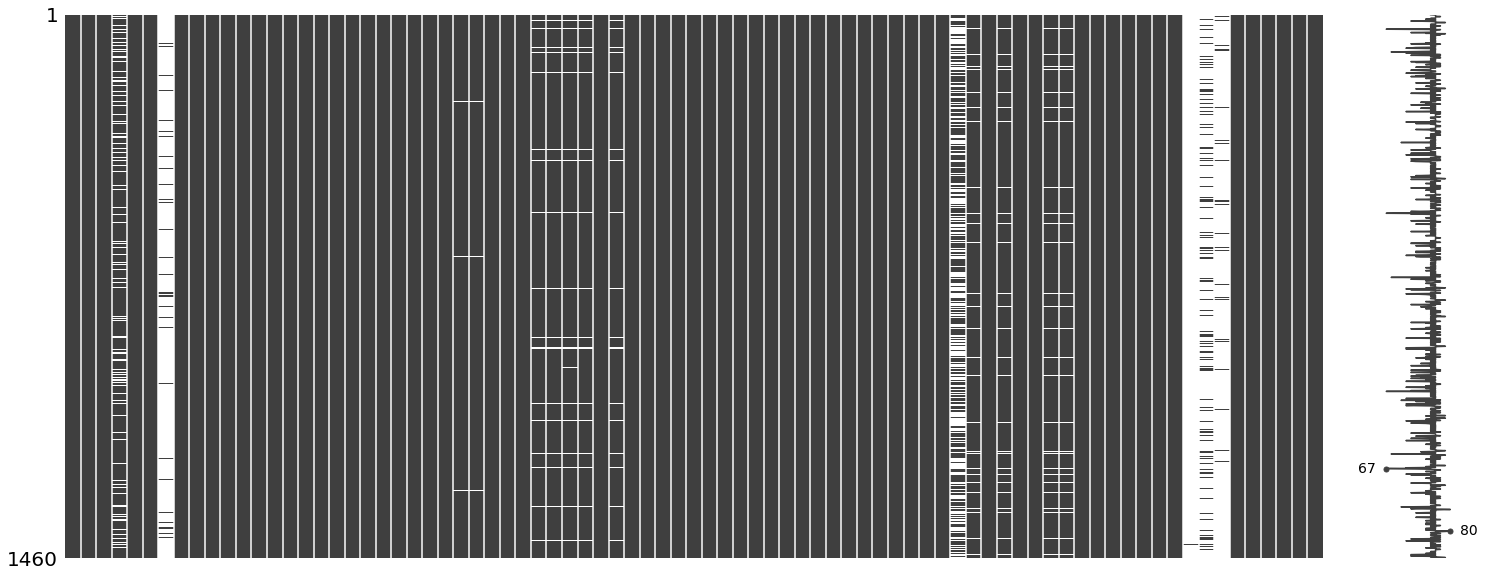

In [10]:
# Create nullity matrix for missing values 

msno.matrix(df)

We can observe that the top 5 variables in the table are missing more than 40% of datapoints. Since these are categorical data, we'll replace NA values with none.  With the remaining variables, we can impute missing values with their respective mode. 

Based on the nullity matrix, it doesn't seem like the data is missing at random. There appears to be a pattern of missing data between pool quality, miscellaneous features, and alley. If the house did not contain those features, they were likely left blank. 


In [11]:
# Get columns with >= 40% missing

missing_df = missing_values_table(df)
missing_columns = list(missing_df[missing_df['% of Total Values'] >= 40].index)
print('We will impute %d columns.' % len(missing_columns))

Your selected dataframe has 81 columns.
There are 18 columns that have missing values.
We will impute 5 columns.


In [12]:
# Repalce NA with None

df[missing_columns] = df[missing_columns].fillna('None')

Now, we will fill remaining missing values with the mode. 

In [13]:
# Imputation by mode

df = df.fillna(df.mode().iloc[0])

Let's check to see whether the null values were missing at random by comparing descriptive statistics before and after dropping the values. 

In [14]:
# Check to see remaining null values 

missing_values_table(df)

Your selected dataframe has 81 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Exploring Data 

Now that we have "cleaned" the data, we can begin exploratory data analysis. EDA is an iterative process to explore the data and summarize characteristics by calculating statistics or visualize methods.  The purpose of EDA is gain an understanding of the data by identifying trends, anomalies, or relationships that might be helpful when making decisions in the modeling process. We can starts out with a high-level overview. If we find an interesting trend, then we can narrow in our focus.



### Univariate Analysis 

We will begin EDA by exploring individual variables, particularly sale price since it is our target variable. 

Text(0.5, 1.0, 'Sale Price')

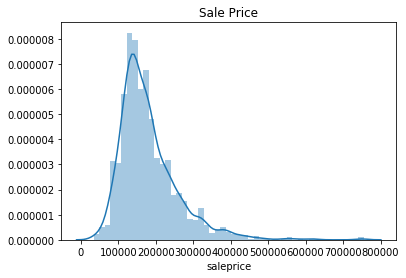

In [15]:
# Plot sale price 

sns.distplot(df.saleprice)
plt.title('Sale Price')

We can observe that the distribution of sale price is heavely skewed to the right. Let's look at some statistics for this feature. 

In [16]:
df['saleprice'].describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

In [17]:
print("Skewness: %f" % df['saleprice'].skew())
print("Kurtosis: %f" % df['saleprice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


The statistics offers insight on the central tendencies of the distribution. The average house in Ames, Iowa sold for \\$180,921 while the median of the distribution is around \\$163,300. That there is also a large price gap between 75% of house prices being listed under \\$214,000 and the maximum value of \\$755,000. A __skewness__ of 1.88 confirms that sale price not normally distributed and is right skewed. A __kurtosis__ of 6.54 indicates a heavy tail distribution that is not symmetrical. We will transform the data to treat skewness later. 

Below are the returned rows for house prices that were more than \\$700,000. These data points will probably be extreme outliers in our dataset. For now, we will keep them aside, but may consider dropping them to increase our accuracy percentage when trying to improve our model's performance.



In [18]:
df.loc[df['saleprice']>=700000]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
691,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,...,555,Ex,MnPrv,None,0,7,2007,WD,Abnorml,745000


### Removing Outliers

Although outliers contain meaningful information, linear regression machine learning models are sensitive to extreme values so we will exclude extreme values. However, if we were to remove all outliers from the training set, our model will not perform well when handling outliers in the testing set. To reach a compromise, we will set the threshold at 3 standard deviations as it will allow us to retain 99% of the dataset. Then, we will replace the extreme values with the threshold since they are close in value.

In [19]:
# Function to detect extreme values and replace with threshold value

def outlier_table(df):
    for column in df.select_dtypes(['int64', 'float64']).columns:
        if df[column].quantile(.9973)<df[column].max():
            threshold = df[column].quantile(.9973)
            df[column] = np.where(df[column] > threshold, int(round(threshold)),df[column])
            if df[column].quantile(0)>df[column].min():
                threshold = df[column].min()
                df[column] = np.where(df[column] < threshold, int(round(threshold)),df[column])
        
        elif df[column].quantile(0)>df[column].min():
            threshold = df[column].min()
            df[column] = np.where(df[column] < threshold, int(round(threshold)),df[column])
        else:
            pass
    return df
            

In [20]:
# Create df2 with extreme values removed 
df2 = df.copy()

# remove sale price column 
df2 = df2.drop(['saleprice'],axis=1) 
df2 = outlier_table(df2)

# adding sale price after removing outliers form other columns 
# we'll take the natural log of sale price later 
df2['saleprice'] = df['saleprice'] 

We'll the impact of removing extreme outliers when graphing the relationship between sale price and explanatory variables. 

### Multivariable Analysis

As previously mentioned in the primary stage of loading the data, this dataset contains two types of features, numeric and categorical. 

__Numerical variables__ are data in numeric form such as integers and floats. Numeric values can be classified into discrete and continuous variables. Discrete numerical variables are whole number values such as the number of rooms in a house. Meanwhile continuous numerical variables may contain any value within some range like sale prices of houses. 

__Categorical variables__ are essentially small groups of categories. Categorical variables can be further categorized into ordinal and nominal variables. Ordinal categorical variables have meaningful order such as a scale of overall quality finish of a house. In contrast, nominal categorical variables purely assign data to groups without intrinsic ordering. We have variables of this type in our dataset such as sale condition, land contour, and zoning classification. 
 

In [21]:
# Numeric variables 

df2.select_dtypes(['int64', 'float64']).columns

Index(['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf',
       'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea',
       'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
       'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars',
       'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch',
       'threessnporch', 'screenporch', 'poolarea', 'miscval', 'saleprice'],
      dtype='object')

In [22]:
# Categorical variables 

df2.select_dtypes(['object']).columns

Index(['id', 'mszoning', 'street', 'alley', 'lotshape', 'landcontour',
       'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition1',
       'condition2', 'bldgtype', 'housestyle', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc',
       'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ',
       'garagetype', 'garageyrblt', 'garagefinish', 'garagequal', 'garagecond',
       'paveddrive', 'poolqc', 'fence', 'miscfeature', 'mosold', 'yrsold',
       'saletype', 'salecondition'],
      dtype='object')

### Looking for Relationships

To determine which explanatory variables we might select for our prediction model, we will explore the correlation between sale price and other variables. __Correlation__ refers to a mutal association between variables. Variables that have a strong correlation, whether it being positive or negative, will affect the target variable. 



#### Numeric Variables

First, we'll take a look at the correlation between sale price and numeric variables.

In [23]:
# Correlation between sale price and numeric variables 

corrmat = df2.corr()
print(corrmat['saleprice'].sort_values(ascending = False),'\n')

saleprice        1.000000
overallqual      0.790982
grlivarea        0.718394
garagecars       0.640409
totalbsmtsf      0.640195
garagearea       0.627388
firstflrsf       0.624533
fullbath         0.560664
totrmsabvgrd     0.535324
masvnrarea       0.474059
fireplaces       0.466929
bsmtfinsf1       0.402366
lotfrontage      0.351627
lotarea          0.342989
wooddecksf       0.324950
openporchsf      0.322656
secondflrsf      0.311295
halfbath         0.284108
bsmtfullbath     0.228364
bsmtunfsf        0.213071
bedroomabvgr     0.169257
screenporch      0.110348
poolarea         0.095084
threessnporch    0.050006
bsmtfinsf2      -0.014274
bsmthalfbath    -0.015957
lowqualfinsf    -0.028883
miscval         -0.034383
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.135038
kitchenabvgr    -0.136018
Name: saleprice, dtype: float64 



The most correlated variables to sale price:
 - overallqual: overall material and finish quality
 - grlivarea: above grade (ground) living area square feet
 - garagecars: size of garage in car capacity
 - garagearea: size of garage in square feet
 - totalbsmtsf: total square feet of basement area
 - firstflrsf: first floor square feet
 - fullbath: full bathrooms above grade 
 - totrmsabvgrd: total rooms above grade (does not include bathrooms)

These results make sense since buyers would be interested in knowing the general living space, quality of the house, and garage capacity.  

Let's see how each variable relates to sale price.

Text(0.5, 1.0, 'Sale Price vs. Overall Quality without outliers')

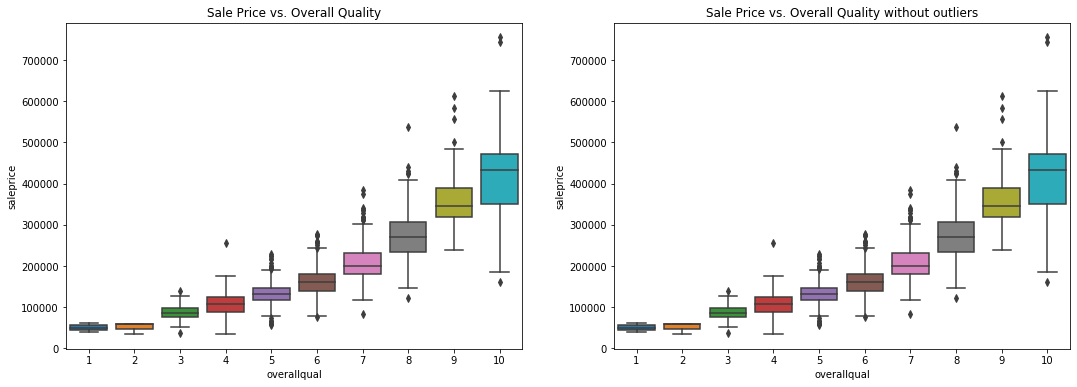

In [24]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.boxplot(x='overallqual', y="saleprice", data=df)
plt.title('Sale Price vs. Overall Quality')

plt.subplot(1,2,2)
sns.boxplot(x='overallqual', y="saleprice", data=df2)
plt.title('Sale Price vs. Overall Quality without outliers')

As one would expect, there is a positive association between overall quality and sale price. As the quality of an item increases, the price will follow in the same direction. We can also see that some extreme values beyond the upper quartile in overall quality score of 10 were removed. 

Text(0.5, 1.0, 'Sale Price vs. Above Grade Living Area (SF) without outliers')

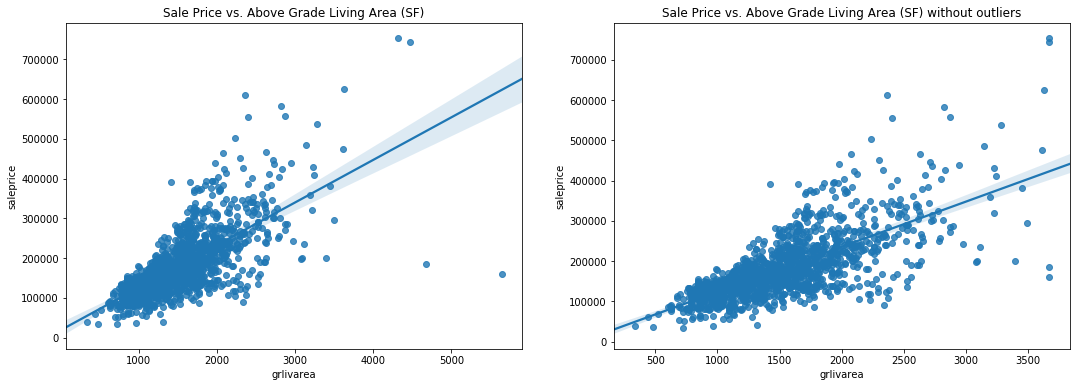

In [25]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.regplot(x="grlivarea", y="saleprice", data=df)
plt.title('Sale Price vs. Above Grade Living Area (SF)')

plt.subplot(1,2,2)
sns.regplot(x="grlivarea", y="saleprice", data=df2)
plt.title('Sale Price vs. Above Grade Living Area (SF) without outliers')

This plot implies that is a positive correlation between the increase of above grade living area and sale price. This is plausible since larger houses will cost more. In the original dataset on the left, there two data points in the lower right corner that appears to be outliers. Houses with living areas more than 4,000 square feet should cost more than houses with smaller living areas. These datapoints were imputed in the right plot. 

Text(0.5, 1.0, 'Sale Price vs. Garage Cars without outliers')

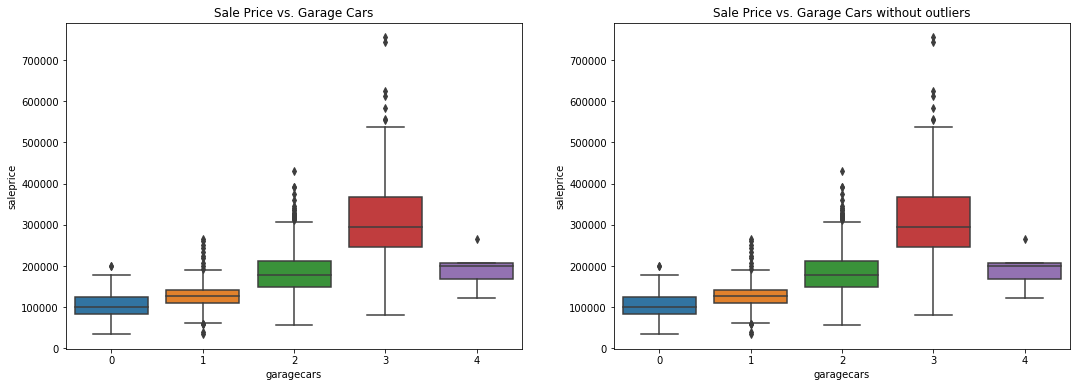

In [26]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.boxplot(x='garagecars', y="saleprice", data=df)
plt.title('Sale Price vs. Garage Cars')

plt.subplot(1,2,2)
sns.boxplot(x='garagecars', y="saleprice", data=df2)
plt.title('Sale Price vs. Garage Cars without outliers')

There appears to be a price increase from zero to three garage cars and then the price suddenly drops at four garage cars. This seems a bit suspicious, but our outlier function didn't dectect those data points as extreme values so we'll leave it at that. 

Text(0.5, 1.0, 'Sale Price vs. Garage Area without outliers')

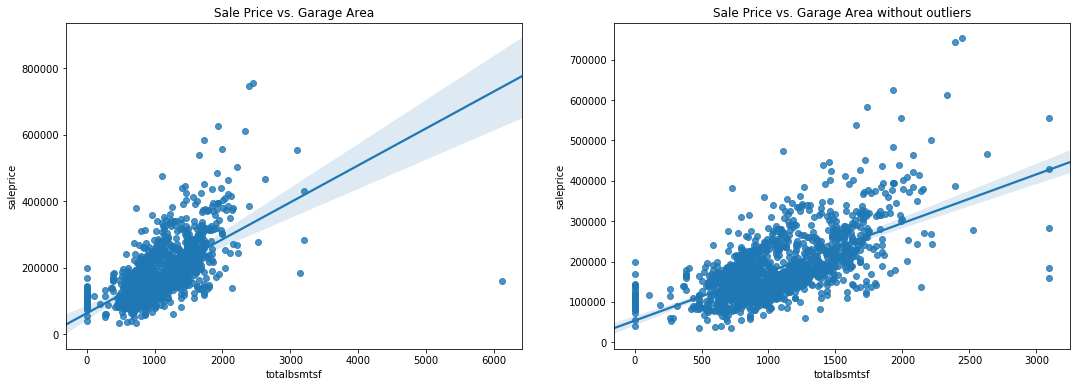

In [27]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.regplot(x="totalbsmtsf", y="saleprice", data=df)
plt.title('Sale Price vs. Garage Area')

plt.subplot(1,2,2)
sns.regplot(x="totalbsmtsf", y="saleprice", data=df2)
plt.title('Sale Price vs. Garage Area without outliers')

Similar to above grade living area, we also see a data points at the lower right corner of this plot. As garage area increase, the price should also increase. The second plot did treat that datapoint. The confidence level on the right plot also greatly reduced from the left plot noting that the extreme value did have a large effect on the data.

Text(0.5, 1.0, 'Sale Price vs. Total square feet of Basement area without outliers')

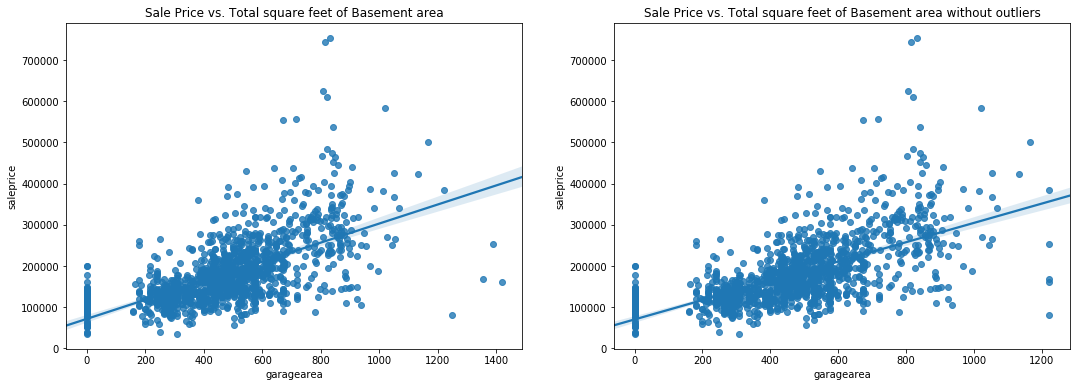

In [28]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.regplot(x="garagearea", y="saleprice", data=df)
plt.title('Sale Price vs. Total square feet of Basement area')

plt.subplot(1,2,2)
sns.regplot(x="garagearea", y="saleprice", data=df2)
plt.title('Sale Price vs. Total square feet of Basement area without outliers')

Again, there a couple of datapoints on the lower right corner that appear to be extreme values. A house with a garage areas more than 1,200 square feet should cost more than \\$100,000.

Text(0.5, 1.0, 'Sale Price vs. First Floor Area (SF) without outliers')

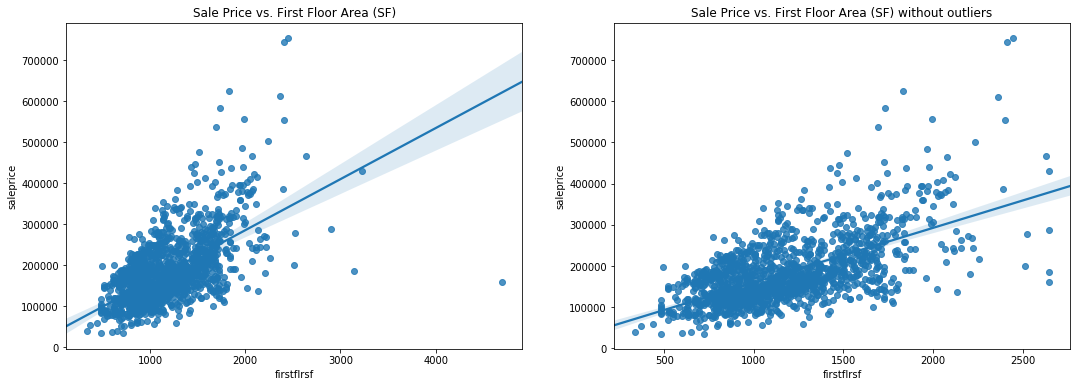

In [29]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.regplot(x="firstflrsf", y="saleprice", data=df)
plt.title('Sale Price vs. First Floor Area (SF)')

plt.subplot(1,2,2)
sns.regplot(x="firstflrsf", y="saleprice", data=df2)
plt.title('Sale Price vs. First Floor Area (SF) without outliers')

Here, we can see two extreme values on the lower right corner and middle top area of the left plot. These values caused the confidence interval to increase as we across the x-axis. Redistributing these values in the right plot lowered the confidence interval. 

Text(0.5, 1.0, 'Sale Price vs. Full Bathrooms without outliers')

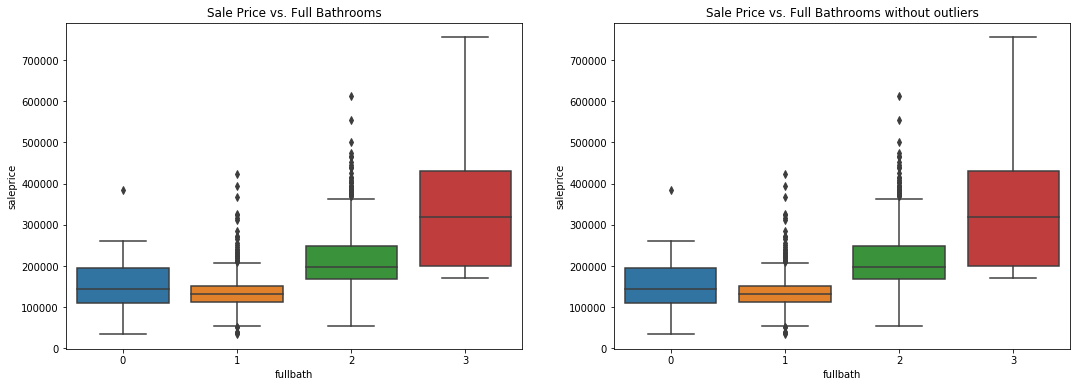

In [30]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.boxplot(x='fullbath', y="saleprice", data=df)
plt.title('Sale Price vs. Full Bathrooms')

plt.subplot(1,2,2)
sns.boxplot(x='fullbath', y="saleprice", data=df2)
plt.title('Sale Price vs. Full Bathrooms without outliers')

The average price of a house with zero full bathrooms is higher than a house with one full bathroom. This maybe due to missing data for full baths. 

Text(0.5, 1.0, 'Sale Price vs. Total Rooms above grade without outliers')

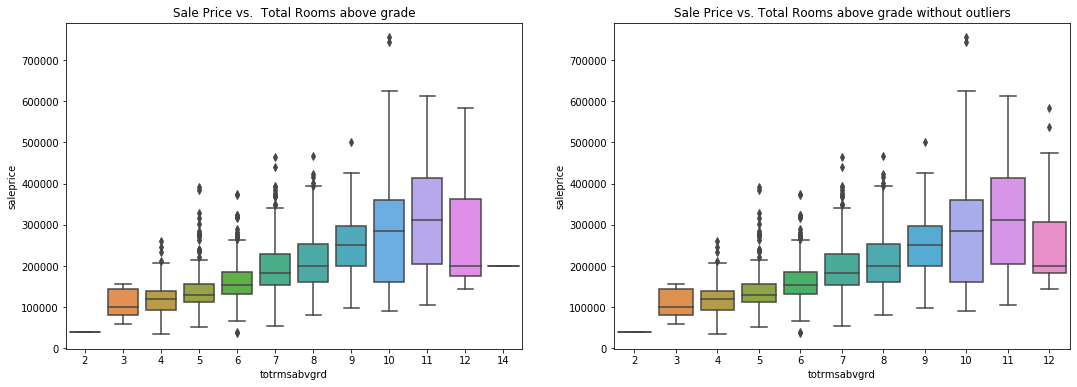

In [31]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.boxplot(x='totrmsabvgrd', y="saleprice", data=df)
plt.title('Sale Price vs.  Total Rooms above grade')

plt.subplot(1,2,2)
sns.boxplot(x='totrmsabvgrd', y="saleprice", data=df2)
plt.title('Sale Price vs. Total Rooms above grade without outliers')

As one would assume, the plots describe a positive association between sale price and the total numbers of rooms above ground. Due to the size, houses with more rooms will probably cost more.

#### Categorical Variables 

Finally, we'll be looking at the effects of categorical variables on sale price. We can visualize this interaction by making bar plots. 

Neighborhoods and age of the homes are important factors that house buyers look for. 

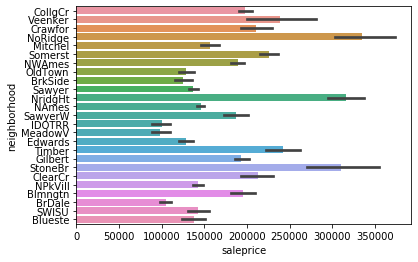

In [32]:
# Failed at trying to sort by sale price
neighborhood = df2.copy()
#neighborhood = neighborhood.groupby('neighborhood')
#neighborhood.apply(lambda x: x.sort_values(by=['saleprice']))
sns.barplot(data=neighborhood, x='saleprice', y='neighborhood')

One would expect houses in ares that are highly rated for in safety, near good schools or close to employment opportunties to be in the higher price range. Homes in Northridge, Northpark Villa, and Stone Brook neighborhoods tend to have three or more bedrooms for a family environment, which would probably cause them to be priced high. 

Before plotting year built, we will create house age groups. 

In [33]:
# Create new house age groups 

df2['yearremodadd'] = pd.to_numeric(df['yearremodadd'])
df2['saleprice'] = pd.to_numeric(df['saleprice'])

df2['houseage'] = pd.cut(df2['yearremodadd'],6,labels=['50+','40-50', '30-40','20-30',
                                                      '10-20','<10'])

Text(0.5, 1.0, 'Sale Price vs. House Remodel/Age')

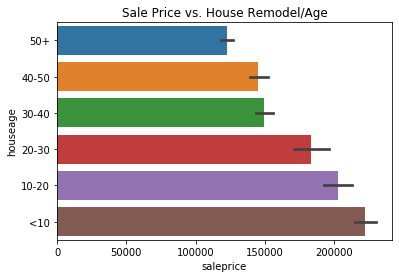

In [34]:
sns.barplot(data = df2, y='houseage',x='saleprice')
plt.title('Sale Price vs. House Remodel/Age')

As one would assume, newer houses that have been renovated will be higher priced. 

## Feature Engineering and Selection

Since we have identified trends and relationship within the dataset, we will out findings to select a set of features for our model. We have learned which numeric values are correlated to sale price. We also have seen the distribution relationship between the sale price and two categorical variables, neighborhoods and year remodeled. 

Before continuing, let's define what feature engineering and selection is. __Feature engineering__ is the process of taking raw data and creating a new feature for the model to map between features and the target. This may involve transforming variables, such as taking the log or one-hot encoding categorical variables. Meanwhile __feature selection__ can be viewed as choosing the most relevant features to the target variable. This could be selecting the highest correlated to target or features with the most variance. Often, these two processes will overlap. 

For this assignment, we will take the following steps for feature engineering:
 * select a few numerical variables and two categorical variables
 * log transformation of sale price
 * one-hot encode for categorical variables
 * creating new variables 
 
We wil do the following for feature selection:
 * remove collinear features 

#### Feature 1: Numeric values 

These are the features that are most correlated to sale price. We will use a heatmap to check for highly __collinear__ features. Collinerity occurs when two or more explanatory variables are highly correlated. This becomes problematic for modeling to estimate the relationship between each explanatory variable and the target variable. 

In [35]:
# Most correlated features 

most_corr = df2.loc[:,['overallqual','grlivarea','garagecars','garagearea','totalbsmtsf',
                    'firstflrsf','fullbath','totrmsabvgrd','saleprice']]


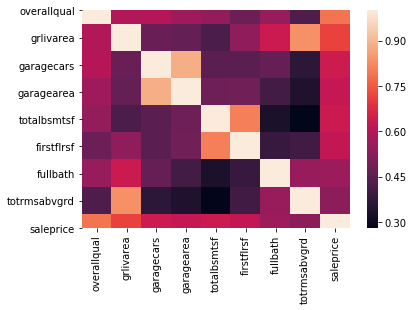

In [36]:
# Heatmap of most correlated variables 

corrmat = most_corr.corr()
sns.heatmap(corrmat)

The variables look relatively independent to each other. We can look at these variables after discovering their coefficent significance when running OLS model.

#### Feature 2: Dummy Variables 
We will be introducing the following categorical variables to the model: neighborhood and year remodel added.

In [37]:
df2 = pd.concat([df2,pd.get_dummies(df2.neighborhood, prefix="neighborhood", drop_first=True)], axis=1)
df2 = pd.concat([df2,pd.get_dummies(df2.houseage, prefix="houseage", drop_first=True)], axis=1)


dummy_column_names = list(pd.get_dummies(df2.neighborhood, prefix="neighborhood", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df2.houseage, prefix="houseage", drop_first=True).columns)

#### Feature 3: Log transformation 

To increase the fit of our model, we will perform log transformation on sale price since it is highly skewed to the right. 

In [38]:
df2['saleprice_log'] = np.log1p(df2['saleprice'])

#### Feature 4: New variables 

We'll also introduce a new variable by combining total basement area, first, and second floor area as total square feet. Lastly, we will add the interaction between total square feet and overall quality of the house.

In [39]:
# Create new variables 
df2['totalsf'] = df2['totalbsmtsf'] + df2['firstflrsf'] + df2['secondflrsf']

df2['int_over_sf'] = df2['totalsf'] * df2['overallqual']

## Evaluating coefficents 

We will determine whether the features we selected are good for the model by testing it on a linear regression model. If the  p-value for a coefficent is less than 0.05, this indicates that the coefficent is not statistically significant and we should consider removing it. 

Then, we will exmaine the __R-squared__ and __adjusted R-squared__ to see how explantory variables perform in each model. R-squared is a statistical measure of how close the data are to the fitted regression line. It is the percentage of the target variation that is explained by a linear model. A zero percentage indicates that the model explains none of the variability of the response data around its mean. In general, the higher the R-squared, the better the model fits the data.

We will also look at the __Akaike Information Criterion (AIC)__ and __Bayesian Information Criterion (BIC)__ when deciding which model performs the best. AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model. Both BIC and AIC attempt to resolve the problem of overfitting by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC than in AIC. For both AIC and BIC, the lower the value the better. Hence, we choose the model with the lowest AIC or BIC value.

In [40]:
# Y is the target variable
Y = df2['saleprice_log']
# X is the feature set
X = df2[['overallqual','grlivarea','garagecars','garagearea','totalbsmtsf','firstflrsf','fullbath','totrmsabvgrd'] + dummy_column_names]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_log   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     246.7
Date:                Thu, 15 Aug 2019   Prob (F-statistic):               0.00
Time:                        14:54:21   Log-Likelihood:                 731.54
No. Observations:                1460   AIC:                            -1387.
Df Residuals:                    1422   BIC:                            -1186.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.7883      0.051    211.465      0.000      10.688      10.888
overallqual              0.0810      0.005     16.069      0.000       0.071       0.091
grlivarea                0.0003   1.91e-05     13.280      0.000       0.000       0.000
garagecars               0.0436      0.013      3.476      0.001       0.019       0.068
garagearea               0.0001   4.29e-05      2.875      0.004    3.92e-05       0.000
totalbsmtsf              0.0001   1.74e-05      7.981      0.000       0.000       0.000
firstflrsf             7.92e-06   2.07e-05      0.383      0.702   -3.26e-05    4.85e-05
fullbath                -0.0136      0.011     -1.243      0.214      -0.035       0.008
totrmsabvgrd            -0.0043      0.005     -0.922      0.357      -0.013       0.005
neighborhood_Blueste    -0.0516      0.113     -0.456      0.648      -0.273       0.170
neighborhood_BrDale     -0.1810      0.055     -3.282      0.001      -0.289      -0.073
neighborhood_BrkSide    -0.0313      0.044     -0.715      0.475      -0.117       0.055
neighborhood_ClearCr     0.1765      0.048      3.704      0.000       0.083       0.270
neighborhood_CollgCr     0.0685      0.039      1.757      0.079      -0.008       0.145
neighborhood_Crawfor     0.1624      0.043      3.735      0.000       0.077       0.248
neighborhood_Edwards    -0.0529      0.041     -1.277      0.202      -0.134       0.028
neighborhood_Gilbert     0.0850      0.041      2.072      0.038       0.005       0.166
neighborhood_IDOTRR     -0.2044      0.047     -4.353      0.000      -0.297      -0.112
neighborhood_MeadowV    -0.1396      0.055     -2.558      0.011      -0.247      -0.033
neighborhood_Mitchel     0.0250      0.044      0.574      0.566      -0.060       0.110
neighborhood_NAmes       0.0341      0.040      0.854      0.393      -0.044       0.113
neighborhood_NPkVill    -0.0093      0.064     -0.145      0.885      -0.135       0.116
neighborhood_NWAmes      0.0483      0.042      1.146      0.252      -0.034       0.131
neighborhood_NoRidge     0.1444      0.046      3.139      0.002       0.054       0.235
neighborhood_NridgHt     0.1635      0.041      4.015      0.000       0.084       0.243
neighborhood_OldTown    -0.1410      0.041     -3.416      0.001      -0.222      -0.060
neighborhood_SWISU      -0.0436      0.050     -0.874      0.382      -0.142       0.054
neighborhood_Sawyer      0.0197      0.043      0.463      0.643      -0.064       0.103
neighborhood_SawyerW     0.0412      0.042      0.974      0.330      -0.042       0.124
neighborhood_Somerst     0.0920      0.040      2.273      0.023       0.013       0.171
neighborhood_StoneBr     0.1944      0.048      4.078      0.000       0.101       0.288
neighborhood_Timber      0.1265      0.044      2.874    

In the table above, we can see that the coefficents for first floor square feet and full bath are insignifcant. Let's try removing those and see how the model performs. 

In [41]:
# Y is the target variable
Y = df2['saleprice_log']
# X is the feature set
X = df2[['overallqual','grlivarea','garagecars','garagearea','totalbsmtsf','totrmsabvgrd'] + dummy_column_names]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_log   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     260.8
Date:                Thu, 15 Aug 2019   Prob (F-statistic):               0.00
Time:                        14:54:21   Log-Likelihood:                 730.71
No. Observations:                1460   AIC:                            -1389.
Df Residuals:                    1424   BIC:                            -1199.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.7807      0.050    217.105      0.000      10.683      10.878
overallqual              0.0809      0.005     16.104      0.000       0.071       0.091
grlivarea                0.0002   1.79e-05     13.908      0.000       0.000       0.000
garagecars               0.0426      0.013      3.407      0.001       0.018       0.067
garagearea               0.0001   4.27e-05      2.991      0.003    4.39e-05       0.000
totalbsmtsf              0.0001   1.23e-05     11.641      0.000       0.000       0.000
totrmsabvgrd            -0.0049      0.005     -1.050      0.294      -0.014       0.004
neighborhood_Blueste    -0.0517      0.113     -0.459      0.646      -0.273       0.169
neighborhood_BrDale     -0.1781      0.055     -3.264      0.001      -0.285      -0.071
neighborhood_BrkSide    -0.0253      0.043     -0.584      0.559      -0.110       0.060
neighborhood_ClearCr     0.1803      0.047      3.804      0.000       0.087       0.273
neighborhood_CollgCr     0.0683      0.039      1.761      0.078      -0.008       0.144
neighborhood_Crawfor     0.1684      0.043      3.902      0.000       0.084       0.253
neighborhood_Edwards    -0.0489      0.041     -1.185      0.236      -0.130       0.032
neighborhood_Gilbert     0.0831      0.041      2.042      0.041       0.003       0.163
neighborhood_IDOTRR     -0.1989      0.046     -4.279      0.000      -0.290      -0.108
neighborhood_MeadowV    -0.1361      0.054     -2.510      0.012      -0.242      -0.030
neighborhood_Mitchel     0.0277      0.043      0.639      0.523      -0.057       0.113
neighborhood_NAmes       0.0401      0.040      1.011      0.312      -0.038       0.118
neighborhood_NPkVill    -0.0158      0.064     -0.248      0.804      -0.140       0.109
neighborhood_NWAmes      0.0486      0.042      1.155      0.248      -0.034       0.131
neighborhood_NoRidge     0.1465      0.046      3.208      0.001       0.057       0.236
neighborhood_NridgHt     0.1637      0.041      4.027      0.000       0.084       0.243
neighborhood_OldTown    -0.1360      0.041     -3.329      0.001      -0.216      -0.056
neighborhood_SWISU      -0.0406      0.050     -0.817      0.414      -0.138       0.057
neighborhood_Sawyer      0.0254      0.042      0.600      0.549      -0.058       0.108
neighborhood_SawyerW     0.0425      0.042      1.006      0.315      -0.040       0.125
neighborhood_Somerst     0.0892      0.040      2.221      0.027       0.010       0.168
neighborhood_StoneBr     0.1956      0.048      4.108      0.000       0.102       0.289
neighborhood_Timber      0.1274      0.044      2.896      0.004       0.041       0.214
neighborhood_Veenker     0.2207      0.058      3.775      0.000       0.106       0.335
houseage_40-50           0.0517      0.017      3.106    

We can see that the R-squared and adjacent r-squared remained the same. However, AIC and BIC dropped in the second model indicating less information loss. Based on these results, we will continue with the explanatory variables in the second model. 

### Split into Training and Testing Sets
In machine learning, we will need to separate our features into two sets, training and testing. __Training set__ is used to train our model along with answers so it can learn to map between features and target variable. The __testing set__ will be used to evaluate the mapping learned by the model since the model is exposed to unseen data. 

In [42]:
# Y is the target variable
Y = df2['saleprice_log']
# X is the feature set
X = df2[['overallqual','grlivarea','garagecars','garagearea','totalbsmtsf','totrmsabvgrd'] + dummy_column_names]

In [43]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

The number of observations in training set is 1168
The number of observations in test set is 292


Now, our features in the training and test sets are assigned to X_train and X_test respectively. 

## Evaluating and Comparing Machine Learning Models

In this section, we will build, train, and evaluate several models for predicting house sale price. We will be comparing models by using the mean absolute error as a baseline. 


### Metric: Mean Absolute Error

There are many metrics that can be used to evaluate the performance of a model. However, to simplify the evaluation process, we will be using the __mean absolute error__(MAE) to determine which model performs the best. MAE is the absolute value of the difference between the predicted value and target value. In short, it determines the accuracy of a prediction. 

### Hyperparameter with Cross Validation

We will choose the best hyperparameters for a model with __cross validation__. Instead of splitting the data into training and testing sets,we will be using K-fold cross validation. The general procedure involves shuffling the dataset randomly and dividing the dataset into K number of folds. For each unique group, we first train on K-1 of folds and then test the performance on the remaining untrained fold. This would repeat K times so that we essentially train on every datapoint. After each test set, the evaluation score is retained and averaged as the model evaluation score.

### Models to Evaluate

We will be comparing four different learning models:
 1. OLS Regression: minimizing the sum of the squares of the differences between the predicted and actual value
 2. Ridge Regression: penalizes sum of squared coefficents (L2 pentalty)
 3. Lasso Regression: penalizes the sum of absolute values of the coefficients (L1 penalty)
 4. Elastic Net Regression: combination of Ridge and Lasso
 
The default hyperparameters from Scikit-Learn will be used for modeling. After elvaulating the performance of each model based on MAE, we will select the better model for further optimization. 

In [44]:
# Function to calculate mean absolute error

def mae(y_test, y_preds_test):
    return np.mean(abs(y_test - y_preds_test))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, Y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [45]:
# Linear Regression

lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 0.1056


In [46]:
# Ridge Regression 

rr = RidgeCV(alphas=alphas, cv=5) 
rr_mae = fit_and_evaluate(rr)

print('Ridge Regression Performance on the test set: MAE = %0.4f' % rr_mae)

Ridge Regression Performance on the test set: MAE = 0.1055


In [47]:
# Lasso Regression 

lar = LassoCV(alphas=alphas, cv=5)
lar_mae = fit_and_evaluate(lar)

print('Lasso Regression Performance on the test set: MAE = %0.4f' % lar_mae)

Lasso Regression Performance on the test set: MAE = 0.1056


In [48]:
# Elastic Net Regression 

er = ElasticNetCV(alphas=alphas, cv=5)
er_mae = fit_and_evaluate(er)

print('Elastic Net Regression Performance on the test set: MAE = %0.4f' % er_mae)

Elastic Net Regression Performance on the test set: MAE = 0.1056


In [49]:
# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Ridge Regression',
                                           'Lasso Regression', 'Elastic Net Regression'],
                                 'mae': [lr_mae, rr_mae, lar_mae,er_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = True)

,model,mae
1,Ridge Regression,0.105522
3,Elastic Net Regression,0.105576
2,Lasso Regression,0.105600
0,Linear Regression,0.105604


#### Which model performed best?
As we can see, all the models performed fairly simiular in terms of accuracy. The average accuracy of the models ranges from 88% to 89%. Based on the MAE, ridge regression had the least amount of error prediction so we will continue with using this model. 

## Introducing other factors 
Since house prices can be affected by many factors, we will introduce additional economic indicators from a different dataset. The economic conditions often impacts an individual's abillity to buy or sell a house. The first indicator we'll introduce is the national __unemployment rate__. If there is high unemployment fewer people would be able to afford to purchase homes, thus the prices around that year are probably lower than when unemployment is low. 

Maybe we will explore __interest rates__. Depending on time the house was sold, interest rates can affect the cost of financing and mortage rates which can influnces the sale price of a house. 